# Pos tagging, analyse des phrases

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            #print "l : ",len(ligne)," ",ligne
            if len(ligne) < 2: # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.split(" ")
            doc.append((mots[0],mots[1]))
    return listeDoc

# =============== chargement ============
filename = "data/wapiti/chtrain.txt" 
filenameT = "data/wapiti/chtest.txt" 

alldocs = load(filename)
alldocsT = load(filenameT)

print (len(alldocs)," docs read")
print (len(alldocsT)," docs (T) read")

print(alldocsT[0])

823  docs read
77  docs (T) read
[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from', 'IN'), ('July', 'NNP'), ('and', 'CC'), ('August', 'NNP'), ("'s", 'POS'), ('near-record', 'JJ'), ('deficits', 'NNS'), ('.', '.')]


Construction des dico et évaluation des deux dictionnaires, un en conservant les majuscules, l'autre uniquement en minuscule

In [21]:
dico = dict()
dicolower = dict()
for d in alldocs : 
    for m,c in d:
        dicolower[m.lower()] = c
        dico[m] = c
            
score=0
scorelower = 0
cpt=0
for d in alldocsT:
    for m,c in d:
        cpt+=1
        if dico.setdefault(m,False)== c:
            score+=1
        if dicolower.setdefault(m.lower(),False)== c:
            scorelower+=1
print("score trouvé : ",score,"/",cpt," : ",score/cpt)
print("score lower trouvé ",scorelower,"/",cpt," : ",scorelower/cpt)


score trouvé :  1433 / 1896  :  0.755801687763713
score lower trouvé  1417 / 1896  :  0.7473628691983122


In [22]:
from collections import Counter
dicoTag = dict()
for d in alldocs : 
    for m,c in d:
        if m.lower() in dicoTag:
            dicoTag[m.lower()].append(c)
        else:
            dicoTag[m.lower()] = [c]

for mot in dicoTag:
    dicoTag[mot] = Counter(dicoTag[mot]).most_common(1)[0][0]
    
plusProbable = Counter(dicoTag.values()).most_common(1)[0][0]


scorePlusProbable = 0
cpt=0
for d in alldocsT:
    for m,c in d:
        cpt+=1
        if dicoTag.setdefault(m.lower(),plusProbable)== c:
            scorePlusProbable+=1
print("score trouvé en remplacant les mots inconnus par la clé la plus fréquente :\n ",scorePlusProbable,"/",cpt," : ",scorePlusProbable/cpt)


score trouvé en remplacant les mots inconnus par la clé la plus fréquente :
  1528 / 1896  :  0.8059071729957806


# Utilitaires HMM 

In [23]:
# allx: liste de séquences d'observations
# allq: liste de séquences d'états
# N: nb états
# K: nb observation

def learnHMM(allx, allq, N, K, initTo1=True):
    if initTo1:
        eps = 1e-5
        A = np.ones((N,N))*eps
        B = np.ones((N,K))*eps
        Pi = np.ones(N)*eps
    else:
        A = np.zeros((N,N))
        B = np.zeros((N,K))
        Pi = np.zeros(N)
    
    for x,q in zip(allx,allq):
       
        Pi[int(q[0])] += 1
        for i in range(len(q)-1):
            A[int(q[i]),int(q[i+1])] += 1
            B[int(q[i]),int(x[i])] += 1
        B[int(q[-1]),int(x[-1])] += 1 # derniere transition
    A = A/np.maximum(A.sum(1).reshape(N,1),1) # normalisation
    B = B/np.maximum(B.sum(1).reshape(N,1),1) # normalisation
    Pi = Pi/Pi.sum()
    return Pi , A, B

def viterbi(x,Pi,A,B):
    T = len(x)
    N = len(Pi)
    logA = np.log(A)
    logB = np.log(B)
    logdelta = np.zeros((N,T))
    psi = np.zeros((N,T), dtype=int)
    S = np.zeros(T)
    logdelta[:,0] = np.log(Pi) + logB[:,x[0]]
    #forward
    for t in range(1,T):
        logdelta[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).max(0) + logB[:,x[t]]
        psi[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).argmax(0)
    # backward
    logp = logdelta[:,-1].max()
    S[T-1] = logdelta[:,-1].argmax()
    for i in range(2,T+1):
        
        S[T-i] = psi[int(S[T-i+1]),T-i+1]
    return S, logp #, delta, psi
 


# Apprentissage par HMM

In [24]:

# alldocs etant issu du chargement des données

buf = [[m for m,c in d ] for d in alldocs]
mots = []
[mots.extend(b) for b in buf]
mots = np.unique(np.array(mots))
nMots = len(mots)+1 # mot inconnu

mots2ind = dict(zip(mots,range(len(mots))))
mots2ind["UUUUUUUU"] = len(mots)

buf2 = [[c for m,c in d ] for d in alldocs]
cles = []
[cles.extend(b) for b in buf2]
cles = np.unique(np.array(cles))
cles2ind = dict(zip(cles,range(len(cles))))

nCles = len(cles)

print(nMots,nCles," in the dictionary")

# mise en forme des données
allx  = [[mots2ind[m] for m,c in d] for d in alldocs]
allxT = [[mots2ind.setdefault(m,len(mots)) for m,c in d] for d in alldocsT]

allq  = [[cles2ind[c] for m,c in d] for d in alldocs]
allqT = [[cles2ind.setdefault(c,len(cles)) for m,c in d] for d in alldocsT]


Pi,A,B=learnHMM(allx, allq, nCles, nMots, initTo1=True)
viterbi(allxT[0],Pi,A,B)
score, cpt = 0,0
confusion = np.zeros((nCles+1,nCles+1))
for x in range(len(allxT)):
    temp = viterbi(allxT[x],Pi,A,B)[0]
    for i in range(len(temp)):
        if temp[i] == allqT[x][i]:
            score += 1
        else:
            confusion[int(temp[i])][int(allqT[x][i])] += 1
        
        cpt += 1
    
print("score trouvé : ",score,"/",cpt," : ",round(score/cpt,2))


    

4570 42  in the dictionary
score trouvé :  1536 / 1896  :  0.81


#  Visualisation

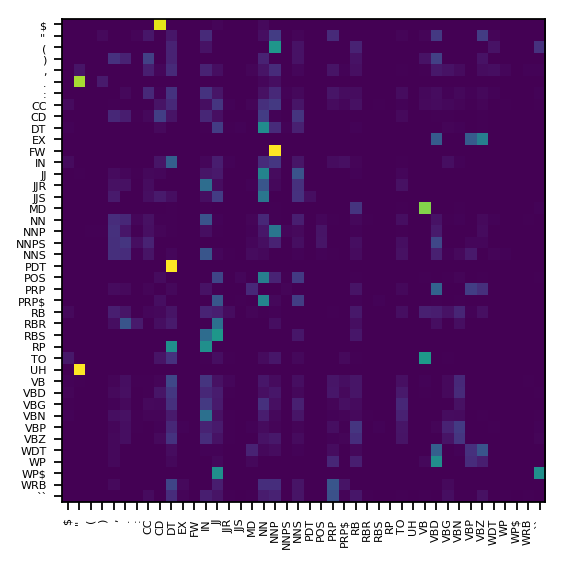

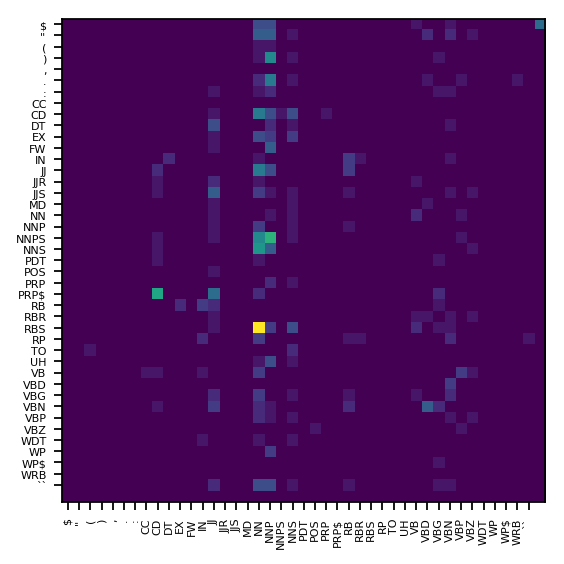

In [25]:
plt.figure(dpi = 160)

plt.imshow(A, interpolation='nearest')
localLabs = cles # liste des POS-TAG
plt.yticks(range(len(localLabs)),localLabs,fontsize=5) # affichage sur l'image
plt.xticks(range(len(localLabs)),localLabs,fontsize=5,rotation='vertical') 
plt.savefig('images/matrice_transition.png')
plt.figure(dpi = 160)

plt.imshow(confusion, interpolation='nearest')
localLabs = cles # liste des POS-TAG
plt.yticks(range(len(localLabs)),localLabs,fontsize=5) # affichage sur l'image
plt.xticks(range(len(localLabs)),localLabs,fontsize=5,rotation='vertical') 

plt.savefig('images/matrice_confusion.png')

# NLTK

In [26]:
from nltk.tag.crf   import CRFTagger


In [27]:
tagger = CRFTagger()
tagger.train(alldocs, u'crf.model') # donner en plus le fichier de stockage du calcul des features


In [28]:

score=0
cpt=0
for d in alldocsT:
    sent = tagger.tag_sents([[i[0] for i in d]])
    for i in range(len(sent[0])):   
        cpt+=1
        if sent[0][i][1]== d[i][1]:
            score+=1
        
print("score trouvé : ",score,"/",cpt," : ",round(score/cpt,4)*100,"%")



score trouvé :  1720 / 1896  :  90.72 %


### Perceptron

In [29]:
from nltk.tag.perceptron    import PerceptronTagger
tagger = PerceptronTagger(load=False)
tagger.train(alldocs)

In [30]:
score=0
cpt=0
for d in alldocsT:
    sent = tagger.tag_sents([[i[0] for i in d]])
    for i in range(len(sent[0])):   
        cpt+=1
        if sent[0][i][1]== d[i][1]:
            score+=1
        
print("score perceptron sur les phrases : ",score,"/",cpt," : ",round(score/cpt,2)*100,"%")

score perceptron sur les phrases :  1739 / 1896  :  92.0 %


In [31]:
score=0
cpt=0
for d in alldocsT:
    for m,c in d:
        cpt+=1
        if tagger.tag([m])[0][1]== c:
            score+=1
print("score perceptron sur les mots: ",score,"/",cpt," : ",round(score/cpt,2)*100,"%")

score perceptron sur les mots:  1510 / 1896  :  80.0 %


## Pos-Tag pré-entraîné 

In [32]:
# Construction de texte à partir de allDocsT

In [33]:
liste_test=[]
for i in range(len(alldocsT)):
    liste_test.append([])
    for m,c in alldocsT[i]:
        liste_test[i].append(m)
    

In [38]:
score = 0
for d in range(len(alldocsT)):
    
    tag_nltk = nltk.pos_tag(liste_test[d])
    for i in range(len(alldocsT[d])):
        
        if tag_nltk[i][1]== alldocsT[d][i][1]:
            score+=1

print("score trouvé avec le pos tagger pré-entrainé de nltk : ",score,"/",cpt," : ",round(score/cpt,2))

score trouvé avec le pos tagger pré-entrainé de nltk :  1813 / 1896  :  0.96
